In [2]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob 
import matplotlib.pyplot as plt

import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from keras_preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from IPython.display import clear_output

Using TensorFlow backend.


In [3]:
path = "./input/"
train_path = path + 'train/'
test_path = path + 'test/'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames

df['id'] = df.path.map(lambda x: x.split("train")[1][1:].split(".")[0]) # keep only the file names in 'id'
labels = pd.read_csv(path+"train_labels.csv") # read the provided labels
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head() # print the first five entrys

,path,id,label
0,./input/train\00001b2b5609af42ab0ab276dd4cd41c...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,./input/train\000020de2aa6193f4c160e398a8edea9...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,./input/train\00004aab08381d25d315384d646f5ce4...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,./input/train\0000d563d5cfafc4e68acb7c9829258a...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,./input/train\0000da768d06b879e5754c43e2298ce4...,0000da768d06b879e5754c43e2298ce48726f722,1


In [4]:
IMG_SIZE = 96
BATCH_SIZE = 64

In [5]:
test_list = os.listdir(test_path)
train_list = os.listdir(train_path)
print("There are " + str(len(train_list)) + " training examples.")
print("There are " + str(len(test_list)) + " test examples.")

There are 220025 training examples.
There are 57458 test examples.


In [6]:
df['label'] = df['label'].astype(str)
train, valid = train_test_split(df, test_size=0.2, stratify = df['label'])

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  vertical_flip = True,
                                  horizontal_flip = True,
                                  rotation_range=90,
                                  zoom_range=0.2, 
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.05,
                                  channel_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale = 1./255) 

In [8]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train, 
                                                    directory = None,
                                                    x_col = 'path', 
                                                    y_col = 'label',
                                                    target_size = (IMG_SIZE,IMG_SIZE),
                                                    class_mode = "binary",
                                                    batch_size=BATCH_SIZE,
                                                    seed = 110318,
                                                    shuffle = True)

valid_generator = test_datagen.flow_from_dataframe(dataframe = valid,
                                                   directory = None,
                                                   x_col = 'path',
                                                   y_col = 'label',
                                                   target_size = (IMG_SIZE,IMG_SIZE),
                                                   class_mode = 'binary',
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = False)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [9]:
from keras.applications.resnet50 import ResNet50

dropout_fc = 0.5

conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (IMG_SIZE,IMG_SIZE,3))

my_model = Sequential()

my_model.add(conv_base)
my_model.add(Flatten())
my_model.add(Dense(256, use_bias=False))
my_model.add(BatchNormalization())
my_model.add(Activation("relu"))
my_model.add(Dropout(dropout_fc))
my_model.add(Dense(1, activation = "sigmoid"))

my_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
C:\Users\Achintya\Anaconda3\envs\PythonGPU\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 3, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718592   
_________________________________________________________________
batch_normalization_

In [10]:
conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [11]:
from keras import optimizers
my_model.compile(optimizers.Adam(0.001), loss = "binary_crossentropy", metrics = ["accuracy"])

In [12]:
train_step_size = train_generator.n // train_generator.batch_size
valid_step_size = valid_generator.n // valid_generator.batch_size

In [13]:
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=2, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [15]:
history = my_model.fit_generator(train_generator,
                                     steps_per_epoch = train_step_size,
                                     epochs = 10,
                                     validation_data = valid_generator,
                                     validation_steps = valid_step_size,
                                     callbacks = [reduce, earlystopper],
                                     verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 952s - loss: 0.2905 - acc: 0.8816 - val_loss: 0.3014 - val_acc: 0.8816
Epoch 2/10
 - 379s - loss: 0.2509 - acc: 0.8992 - val_loss: 0.2902 - val_acc: 0.8854
Epoch 3/10
 - 379s - loss: 0.2351 - acc: 0.9063 - val_loss: 0.2624 - val_acc: 0.8968
Epoch 4/10
 - 378s - loss: 0.2216 - acc: 0.9122 - val_loss: 0.2682 - val_acc: 0.8969

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/10
 - 380s - loss: 0.2022 - acc: 0.9203 - val_loss: 0.2571 - val_acc: 0.9009
Epoch 6/10
 - 381s - loss: 0.1947 - acc: 0.9240 - val_loss: 0.2288 - val_acc: 0.9126
Epoch 7/10
 - 380s - loss: 0.1893 - acc: 0.9256 - val_loss: 0.2282 - val_acc: 0.9108
Epoch 8/10
 - 381s - loss: 0.1871 - acc: 0.9257 - val_loss: 0.2291 - val_acc: 0.9120

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 9/10
 - 380s - loss: 0.1830 - acc: 0.9283 - val_loss: 0.2299 - val_acc: 0.9121

Epoch 00009: ReduceLRO

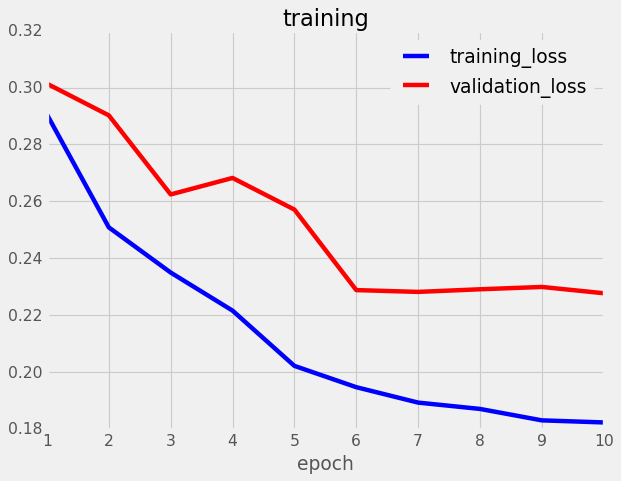

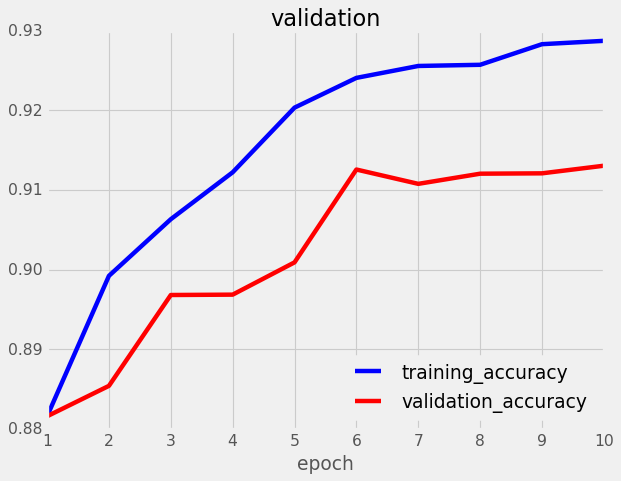

In [38]:
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.style.use('fivethirtyeight')

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.savefig("training.png", bbox_inches='tight', dpi=300)
plt.show()

plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.savefig("validation.png", bbox_inches='tight', dpi=300)
plt.show()

In [45]:
roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(valid,
                                                                                  x_col = 'path',
                                                                                  y_col = 'label',
                                                                                  target_size = (IMG_SIZE,IMG_SIZE),
                                                                                  class_mode = 'binary',
                                                                                  batch_size = BATCH_SIZE,
                                                                                  shuffle = False)
predictions = my_model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=2)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

Found 44005 validated image filenames belonging to 2 classes.


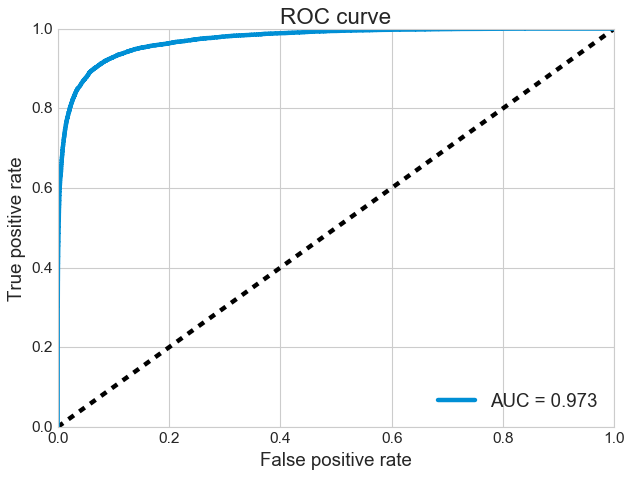

In [46]:
plt.style.use('seaborn-whitegrid')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('ROC_PLOT.png', bbox_inches='tight', dpi=300)
plt.show()

In [18]:
test_df = pd.DataFrame({'path': glob(os.path.join(test_path,'*.tif'))}) # load the filenames
test_df['id'] = test_df.path.map(lambda x: x.split("test")[1][1:].split(".")[0]) # keep only the file names in 'id'
test_df.head() 

,path,id
0,./input/test\00006537328c33e284c973d7b39d34080...,00006537328c33e284c973d7b39d340809f7271b
1,./input/test\0000ec92553fda4ce39889f9226ace43c...,0000ec92553fda4ce39889f9226ace43cae3364e
2,./input/test\00024a6dee61f12f7856b0fc6be20bc7a...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,./input/test\000253dfaa0be9d0d100283b22284ab2f...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,./input/test\000270442cc15af719583a8172c87cd2b...,000270442cc15af719583a8172c87cd2bd9c7746


In [19]:
tta_datagen = ImageDataGenerator(rescale=1./255, #Normalise
                                 vertical_flip = True,
                                 horizontal_flip = True,
                                 rotation_range=90,
                                 zoom_range=0.2, 
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.05,
                                 channel_shift_range=0.1)

In [24]:
tta_steps = 5
submission = pd.DataFrame()
for index in range(0, len(test_df)):
    data_frame = pd.DataFrame({'path': test_df.iloc[index,0]}, index=[index])
    data_frame['id'] = data_frame.path.map(lambda x: x.split("test")[1][1:].split(".")[0])
    img_path = data_frame.iloc[0,0]
    test_img = cv2.imread(img_path)
    test_img = cv2.resize(test_img,(IMG_SIZE,IMG_SIZE))
    test_img = np.expand_dims(test_img, axis = 0)  
    predictionsTTA = []
    for i in range(0, tta_steps):
        preds = my_model.predict_generator(tta_datagen.flow_from_dataframe(dataframe = data_frame,
                                                                           directory = None,
                                                                           x_col = 'path',
                                                                           target_size = (IMG_SIZE, IMG_SIZE),
                                                                           class_mode = None,
                                                                           batch_size = 1,
                                                                           shuffle = False), steps = 1)
        predictionsTTA.append(preds)
    
    clear_output()
    prediction_entry = np.array(np.mean(predictionsTTA, axis=0))
    data_frame['label'] = prediction_entry
    submission = pd.concat([submission, data_frame[['id', 'label']]])
    

In [27]:
submission.set_index('id')
submission.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.955233
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.581447
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.849593
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.537229
4,000270442cc15af719583a8172c87cd2bd9c7746,0.018827


In [28]:
submission.to_csv('submission.csv', index=False, header=True)

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [48]:
model_json = my_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
my_model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [50]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk
